## Import Packages

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import MiniBatchKMeans
import geopandas as gpd
import random

### Setting seed of file

In [2]:
seed_state = random.getstate()
current_seed = seed_state[1][0]

print("Current seed:", current_seed)
seed_value = 123  # The seed value you want to set
np.random.seed(seed_value)  # Set the seed for NumPy's random number generator
#2147483648

Current seed: 2147483648


## Import Files

In [3]:
shapefile_folder = '1270055001_sa2_2016_aust_shape\SA2_2016_AUST.shp'
australia = gpd.read_file(shapefile_folder)

In [4]:
df = pd.read_csv('clean_data.csv')
# Convert SA2 to string 
df['SA2'] = df['SA2'] .astype(str) 

## Normalised Data 

In [5]:
df_norm = pd.DataFrame()
df_norm = df[['HHSIZE_normalised', 'TOTALVEHS_normalised', 'INC_normalised','DWELLTYPE_Separate House', 'age_profile']].copy()
df_norm.loc[:, 'owndwell'] = df['OWNDWELL_Fully Owned'] | df['OWNDWELL_Being Purchased']
num_rows = df_norm.shape[0]
df_norm.head()

,HHSIZE_normalised,TOTALVEHS_normalised,INC_normalised,DWELLTYPE_Separate House,age_profile,owndwell
0,0.125,0.4,0.724725,1,1,1
1,0.125,0.2,0.219720,1,0,1
2,0.125,0.2,0.219720,1,0,1
3,0.125,0.4,0.945946,0,1,1
4,0.125,0.4,0.945946,0,1,1


## Boolean Data 

In [6]:
high_inc = df['INC'].quantile(0.9)
df_bool = pd.DataFrame()
df_bool["veh2"] = df['TOTALVEHS'].apply(lambda x: 1 if x >= 2 else 0)
df_bool["highinc"] = df['INC'].apply(lambda x: 1 if x >= high_inc else 0)
df_bool["house"] = df['DWELLTYPE_Separate House']
df_bool["ownner"] = (df['OWNDWELL_Being Purchased'] | df['OWNDWELL_Fully Owned']).astype(int)
df_bool["age"] = df['age_profile']
df_bool["hhsize"] = df['HHSIZE'].apply(lambda x: 1 if x >= 2 else 0)
df_bool.head()

,veh2,highinc,house,ownner,age,hhsize
0,1,0,1,1,1,1
1,0,0,1,1,0,1
2,0,0,1,1,0,1
3,1,1,0,1,1,1
4,1,1,0,1,1,1


## Run Clustering Algorithm

In [7]:
data = df_bool.values
n_clusters = 10
batch_size = 3072
mbkmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, n_init=10)
for i in range(0, len(data), batch_size):
    mbkmeans.partial_fit(data[i:i+batch_size])

In [8]:
# Data grouped by cluster 

labels = mbkmeans.predict(data)
df_bool['cluster'] = labels
df['cluster'] = labels
df_bool.groupby('cluster').mean()
group_kmeans_bool = df_bool.groupby('cluster').mean()
group_kmeans_bool.head(n_clusters)

,veh2,highinc,house,ownner,age,hhsize
cluster,,,,,,
0,0.258781,0.015372,1.000000,0.158003,0.196541,0.828019
1,1.000000,0.000000,0.905521,0.925067,0.833851,1.000000
2,0.032210,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.064937,0.000000,0.625507,1.000000,0.000000,0.000000
4,0.380653,0.094580,0.000000,0.000000,1.000000,1.000000
5,0.000000,1.000000,0.742745,0.805235,0.937840,1.000000
6,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
7,0.277819,0.057866,0.000000,0.000000,0.000000,1.000000
8,1.000000,1.000000,0.927564,0.920057,0.744127,1.000000


In [9]:
# Size of each cluster 
grouped = df.groupby('cluster')
group_sizes = grouped.size()
total_count = group_sizes.sum()
percentage_breakdown = (group_sizes / total_count) * 100
result = pd.DataFrame({'cluster': percentage_breakdown.index, 'percentage_breakdown': percentage_breakdown.values})
result.head(n_clusters)

,cluster,percentage_breakdown
0,0,9.589813
1,1,39.884612
2,2,5.334024
3,3,14.602525
4,4,4.758396
5,5,1.447271
6,6,7.861737
7,7,4.819664
8,8,8.852695
9,9,2.849263


In [10]:
# Selecting only EV owning cluster to be mapped
cluster = 8
ev_counts = df[df['cluster'] == cluster].groupby('SA2').size().reset_index(name='EVs')
sa2_counts = df['SA2'].value_counts().reset_index().rename(columns={'index': 'SA2', 'SA2': 'SA2_count'})
result = ev_counts.merge(sa2_counts, on='SA2', how='outer').fillna(0)
result['percentage'] = result['EVs'] / result['SA2_count'] * 100

# Dataframe containing geospatial and EV data 
merged_df = australia.merge(result, left_on='SA2_MAIN16', right_on='SA2', how='inner')

<Figure size 1000x800 with 0 Axes>

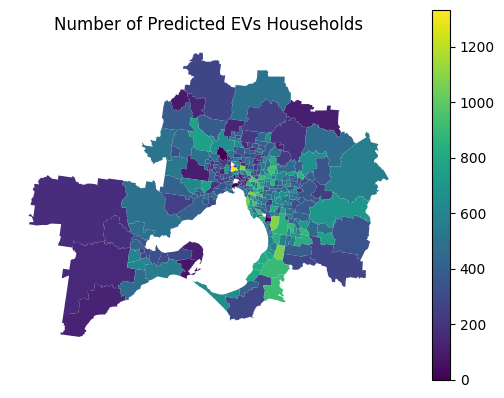

<Figure size 1000x800 with 0 Axes>

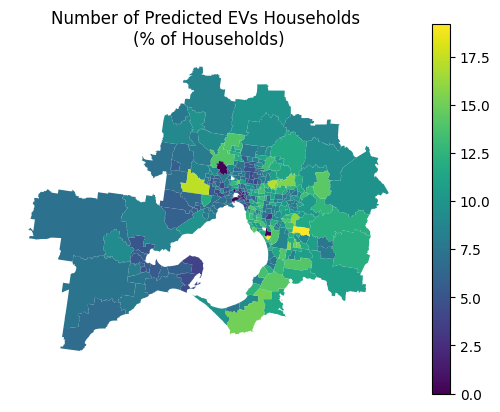

In [12]:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

cmap = 'viridis'
# 'YlGnBu' ''viridis' 
plot_size = (10,8)

plt.figure(figsize=plot_size)

# axs[0].set_title(f'')
# axs[0].axis('off')

ax1 = merged_df.plot(column=merged_df["EVs"], cmap=cmap, legend=True)
ax1.set_xticks([])  
ax1.set_yticks([])  
ax1.set_title("Number of Predicted EVs Households")  # Set the title
# plt.text(0.5, -0.1, f"{int(ev_total_true_poa)} EVs", fontsize=subtitle_fontsize, transform=ax1.transAxes, ha='center')  # Add subtitle
ax1.axis('off')
plt.show()

# merged_df.plot(ax=axs[1], column=merged_df["percentage"], cmap=cmap, legend=True)
# axs[1].set_title(f'Number of Predicted EVs Households \n(% of Households)')
# axs[1].axis('off')
# plt.show()


plt.figure(figsize=plot_size)
ax2 = merged_df.plot(column=merged_df["percentage"], cmap=cmap, legend=True)
ax2.set_xticks([])  #
ax2.set_yticks([])  
ax2.set_title("Number of Predicted EVs Households \n(% of Households)")  
# # plt.text(0.5, -0.1, f"{int(ev_total_true_poa)} EVs", fontsize=subtitle_fontsize, transform=ax1.transAxes, ha='center')  # Add subtitle
ax2.axis('off')
plt.show()

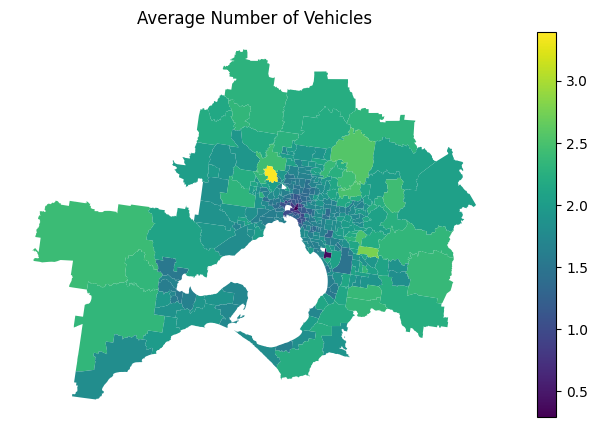

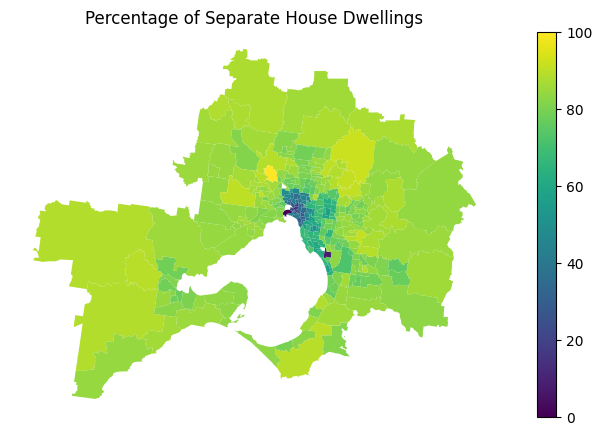

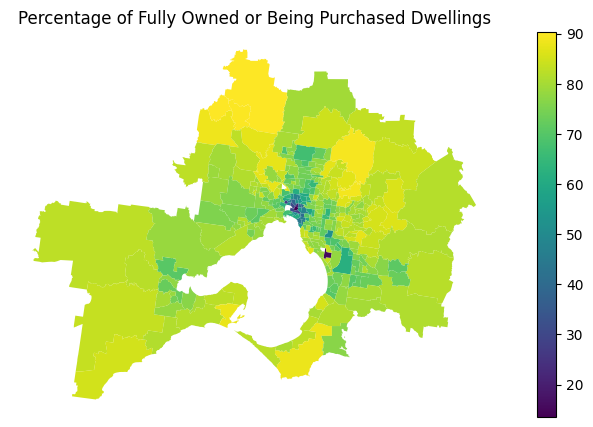

In [13]:
import matplotlib.pyplot as plt
my_cmap = 'viridis'
#"YlGnBu"
#"viridis"
# Figure 1: Average Number of Vehicles
fig1, ax1 = plt.subplots(figsize=(10, 5))
totalvehs_by_lga = df.groupby('SA2')['TOTALVEHS'].mean().reset_index()
lga_with_totalvehs = australia.merge(totalvehs_by_lga, left_on='SA2_MAIN16', right_on='SA2', how='inner')
lga_with_totalvehs.plot(column='TOTALVEHS', cmap=my_cmap, legend=True, ax=ax1)
ax1.set_title('Average Number of Vehicles')
ax1.axis('off')

# Figure 2: Percentage of Separate House Dwellings
fig2, ax2 = plt.subplots(figsize=(10, 5))
sepHouse_by_lga = df.groupby('SA2')['DWELLTYPE_Separate House'].mean().reset_index()
sepHouse_by_lga['DWELLTYPE_Separate House'] *= 100
lga_with_sepHouse = australia.merge(sepHouse_by_lga, left_on='SA2_MAIN16', right_on='SA2', how='inner')
lga_with_sepHouse.plot(column='DWELLTYPE_Separate House', cmap=my_cmap, legend=True, ax=ax2)
ax2.set_title('Percentage of Separate House Dwellings')
ax2.axis('off')

# Figure 3: Percentage of Fully Owned or Being Purchased Dwellings
fig3, ax3 = plt.subplots(figsize=(10, 5))
df['own'] = df['OWNDWELL_Being Purchased'] + df['OWNDWELL_Fully Owned']
ownHouse_by_lga = df.groupby('SA2')['own'].mean().reset_index()
ownHouse_by_lga['own'] *= 100
lga_with_ownHouse = australia.merge(ownHouse_by_lga, left_on='SA2_MAIN16', right_on='SA2', how='inner')
lga_with_ownHouse.plot(column='own', cmap=my_cmap, legend=True, ax=ax3)
ax3.set_title('Percentage of Fully Owned or Being Purchased Dwellings')
ax3.axis('off')

# Show the individual figures
plt.show()


# Income

In [14]:
hhinc_by_lga = df.groupby('SA2')['INC'].mean().reset_index()
lga_with_hhinc = australia.merge(hhinc_by_lga, left_on='SA2_MAIN16', right_on='SA2', how='inner')

In [15]:
hhinc_90th_percentile = np.percentile(df["INC"], 90)
count_greater_90th_percentile = df[df['INC'] >= hhinc_90th_percentile].groupby('SA2').size().reset_index(name='highinccount')
count_greater_90th_percentile
df_highinc = count_greater_90th_percentile[['SA2', 'highinccount']]
lga_with_high_hhinc = australia.merge(count_greater_90th_percentile, left_on='SA2_MAIN16', right_on='SA2', how='inner')

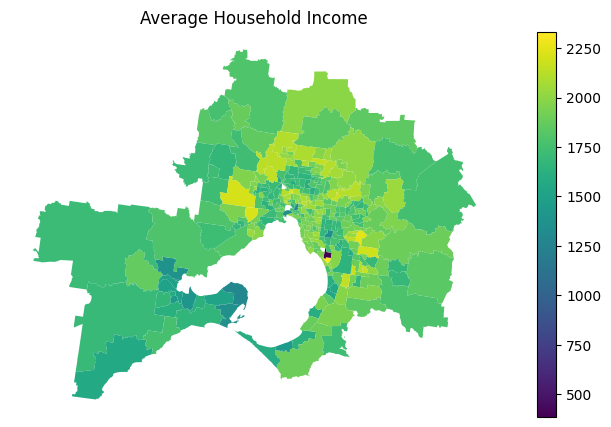

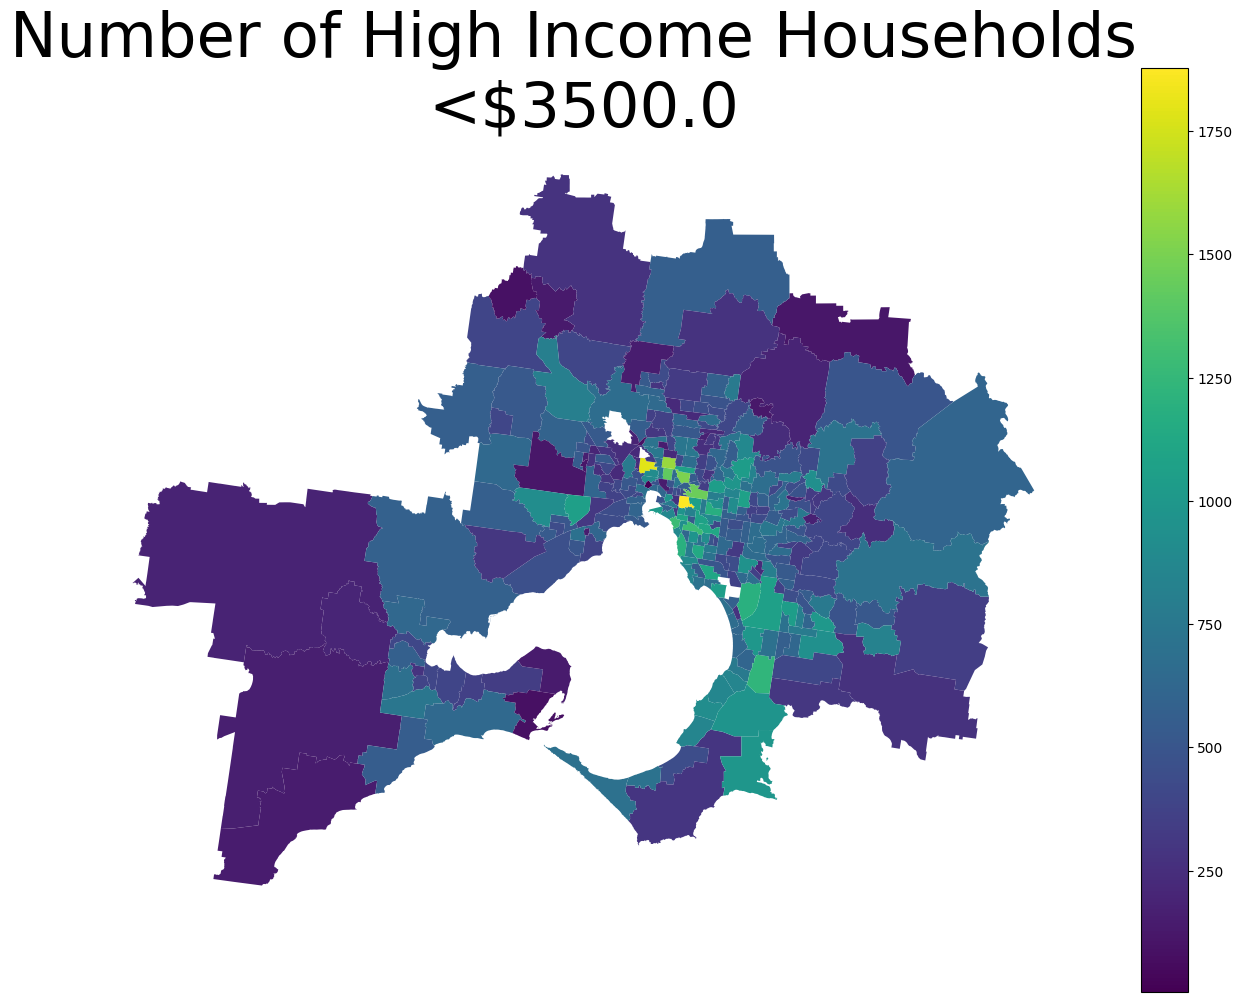

In [19]:
import matplotlib.pyplot as plt

title_fontsize = 45
plot_x = 16
plot_y = 12

# Create two separate figures and axes
fig1, ax1 = plt.subplots(figsize=(10, 5))
fig2, ax2 = plt.subplots(figsize=(plot_x, plot_y))

# Plot the first map on the first figure
lga_with_hhinc.plot(column='INC', cmap='viridis', legend=True, ax=ax1)
ax1.set_title('Average Household Income')
ax1.axis('off')

# Plot the second map on the second figure
lga_with_high_hhinc.plot(column='highinccount', cmap='viridis', legend=True, ax=ax2)
ax2.set_title(f'Number of High Income Households \n<${hhinc_90th_percentile}', fontsize=title_fontsize)
ax2.axis('off')

# Show both figures separately
plt.show()


In [64]:
merged_df["EVs"].sum()

148394.0

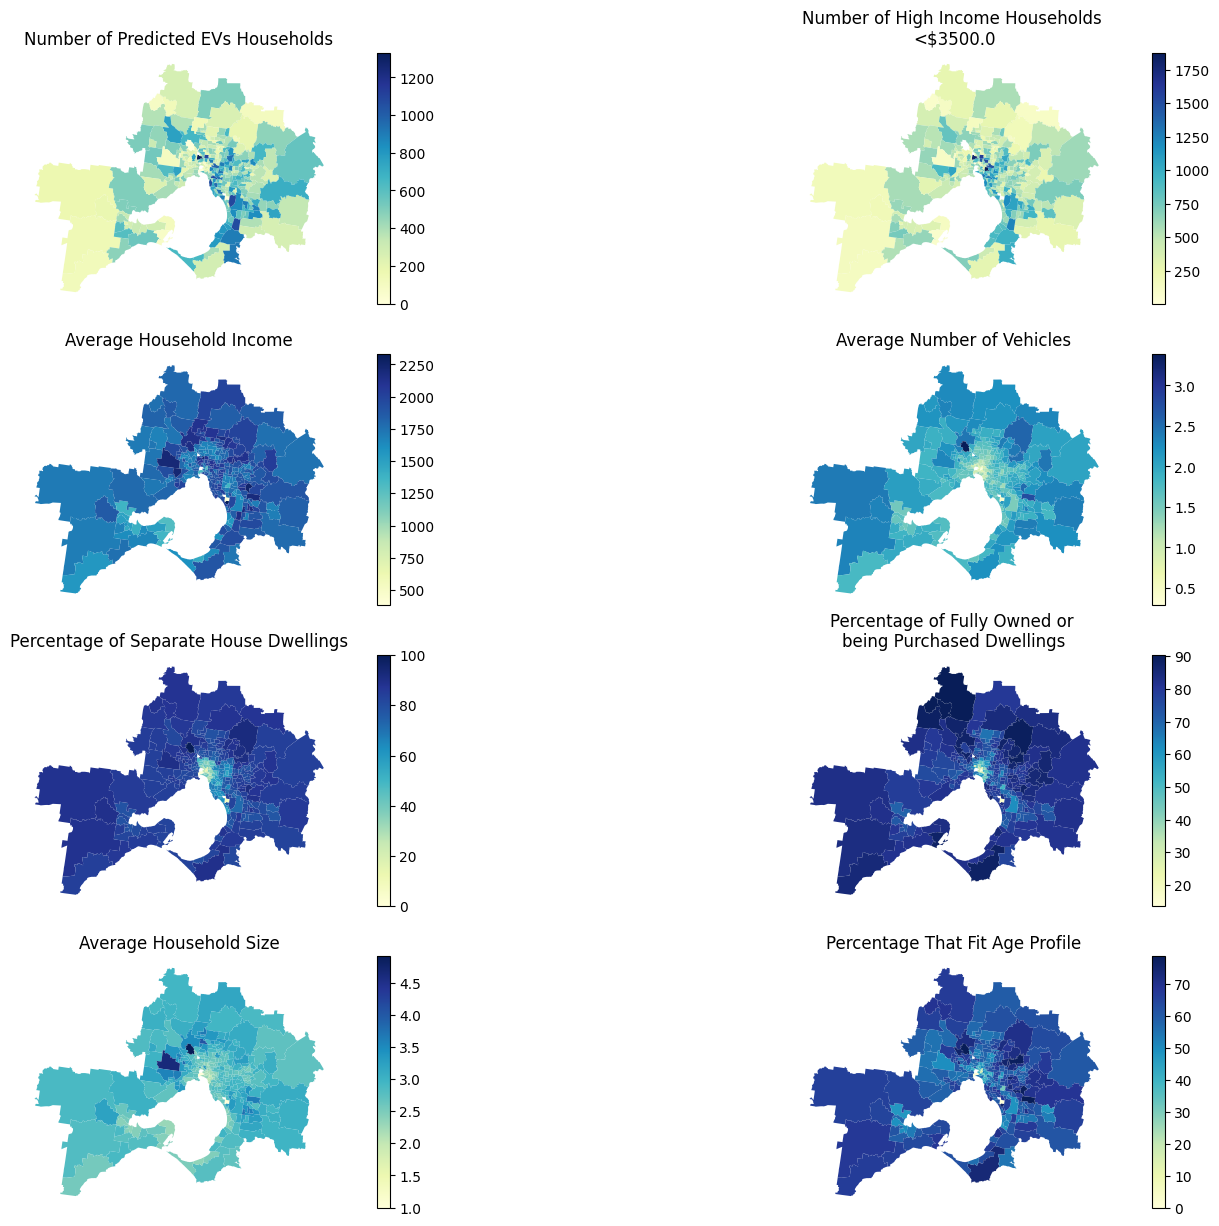

In [82]:


# plot_size = (10,8)
# plt.figure(figsize=plot_size)
# ax1 = merged_df.plot(column=merged_df["EVs"], cmap='viridis', legend=True)
# ax1.set_xticks([])  # Turn off x-axis ticks
# ax1.set_yticks([])  # Turn off y-axis ticks
# ax1.set_title("Number of Predicted EVs Households")  # Set the title
# # plt.text(0.5, -0.1, f"{int(ev_total_true_poa)} EVs", fontsize=subtitle_fontsize, transform=ax1.transAxes, ha='center')  # Add subtitle
# ax1.axis('off')
# plt.show()

fig, axs = plt.subplots(4, 2, figsize=(20, 15), gridspec_kw={'hspace': 0.2, 'wspace': 0})
merged_df.plot(ax=axs[0,0], column=merged_df["EVs"], cmap='YlGnBu', legend=True)
axs[0,0].set_title(f'Number of Predicted EVs Households')
axs[0,0].axis('off')

lga_with_high_hhinc.plot(ax=axs[0,1], column='highinccount', cmap='YlGnBu', legend=True)
axs[0,1].set_title(f'Number of High Income Households \n<${hhinc_90th_percentile}')
axs[0,1].axis('off')

lga_with_hhinc.plot(column='INC', cmap='YlGnBu', legend=True, ax=axs[1,0])
axs[1,0].set_title(f'Average Household Income')
axs[1,0].axis('off')

lga_with_totalvehs.plot(column='TOTALVEHS', cmap='YlGnBu', legend=True, ax=axs[1,1])
axs[1,1].set_title(f'Average Number of Vehicles')
axs[1,1].axis('off')

lga_with_sepHouse.plot(column='DWELLTYPE_Separate House', cmap='YlGnBu', legend=True, ax=axs[2,0])
axs[2,0].set_title(f'Percentage of Separate House Dwellings')
axs[2,0].axis('off')

lga_with_ownHouse.plot(column='own', cmap='YlGnBu', legend=True, ax=axs[2,1])
axs[2,1].set_title(f'Percentage of Fully Owned or \nbeing Purchased Dwellings')
axs[2,1].axis('off')


hhsize_by_lga = df.groupby('SA2')['HHSIZE'].mean().reset_index()
lga_with_hhsize= australia.merge(hhsize_by_lga, left_on='SA2_MAIN16', right_on='SA2', how='inner')
lga_with_hhsize.plot(column='HHSIZE', cmap='YlGnBu', legend=True, ax=axs[3,0])
axs[3,0].set_title(f'Average Household Size')
axs[3,0].axis('off')

age_by_lga = df.groupby('SA2')['age_profile'].mean().reset_index()
age_by_lga['age_profile'] *= 100
lga_with_age= australia.merge(age_by_lga, left_on='SA2_MAIN16', right_on='SA2', how='inner')
lga_with_age.plot(column='age_profile', cmap='YlGnBu', legend=True, ax=axs[3,1])
axs[3,1].set_title(f'Percentage That Fit Age Profile')
axs[3,1].axis('off')

plt.show()




In [ ]:
merged_df.to_file("Predictions\\kmean_sa2_pred.geojson", driver='GeoJSON')
lga_with_high_hhinc.to_file("Predictions\\kmean_high_inc.geojson", driver='GeoJSON')
lga_with_hhinc.to_file("Predictions\\kmean_inc.geojson", driver='GeoJSON')
lga_with_totalvehs.to_file("Predictions\\kmean_totalvehs.geojson", driver='GeoJSON')
lga_with_sepHouse.to_file("Predictions\\kmean_sepHouse.geojson", driver='GeoJSON')
lga_with_ownHouse.to_file("Predictions\\kmean_ownHouse.geojson", driver='GeoJSON')
lga_with_hhsize.to_file("Predictions\\kmean_hhsize.geojson", driver='GeoJSON')
lga_with_age.to_file("Predictions\\kmean_age.geojson", driver='GeoJSON')

In [66]:
df.to_csv('clustered.csv', index=False)

KeyboardInterrupt: 